<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [12]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams 
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_followers',
       'pref_attach_followees'],
      dtype='object')

In [4]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [5]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [16]:
train_scores = []
test_scores = []
for max_depth in [1, 2, 3, 5, 7, 10]:
    train_score = []
    test_score = []
    for n_estimators in [5, 10, 100, 500]:
        clf = xgb.XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,booster='gbtree',verbosity = 0)
        clf.fit(df_final_train,y_train)
        train_sc = f1_score(y_train,clf.predict(df_final_train))
        test_sc = f1_score(y_test,clf.predict(df_final_test))
        test_score.append(test_sc)
        train_score.append(train_sc)
        print('| max_depth = ',max_depth,'| n_estimators = ',n_estimators,'| > Train Score : ',train_sc,'test Score : ',test_sc)
    train_scores.append(train_score)
    test_scores.append(test_score)

| max_depth =  1 | n_estimators =  5 | > Train Score :  0.8758240400705277 test Score :  0.871075726047227
| max_depth =  1 | n_estimators =  10 | > Train Score :  0.8756093725428526 test Score :  0.8709224992082523
| max_depth =  1 | n_estimators =  100 | > Train Score :  0.9641068194007346 test Score :  0.9178041668427503
| max_depth =  1 | n_estimators =  500 | > Train Score :  0.9740322776362093 test Score :  0.9086832801586616
| max_depth =  2 | n_estimators =  5 | > Train Score :  0.9138240763113386 test Score :  0.9074915949506268
| max_depth =  2 | n_estimators =  10 | > Train Score :  0.9248444628784738 test Score :  0.9194707782060632
| max_depth =  2 | n_estimators =  100 | > Train Score :  0.9754968827993169 test Score :  0.8929540481400438
| max_depth =  2 | n_estimators =  500 | > Train Score :  0.985727782579854 test Score :  0.8891429576535772
| max_depth =  3 | n_estimators =  5 | > Train Score :  0.9286822364366619 test Score :  0.9235675606258428
| max_depth =  3 | n

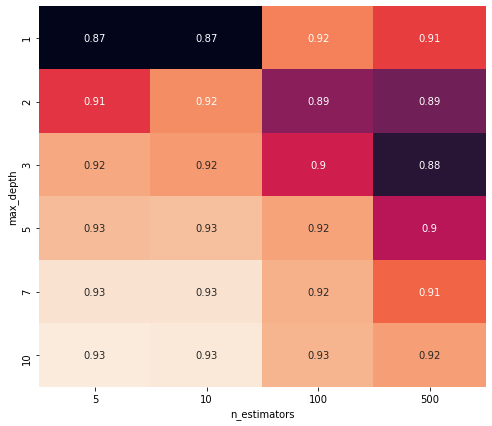

In [23]:
fig = plt.figure(figsize = (8,7))
sns.heatmap(test_scores,annot= True,xticklabels=[5, 10, 100, 500], yticklabels=[1, 2, 3, 5, 7, 10],cbar = False)
plt.xlabel("n_estimators")
plt.ylabel('max_depth')
plt.show()

In [25]:
best_clf = xgb.XGBClassifier(max_depth=10,n_estimators=5,booster='gbtree',verbosity = 0)
best_clf.fit(df_final_train,y_train)
y_train_pred = best_clf.predict(df_final_train)
y_test_pred = best_clf.predict(df_final_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9781790210922635
Test f1 score 0.9344435075885329


In [26]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


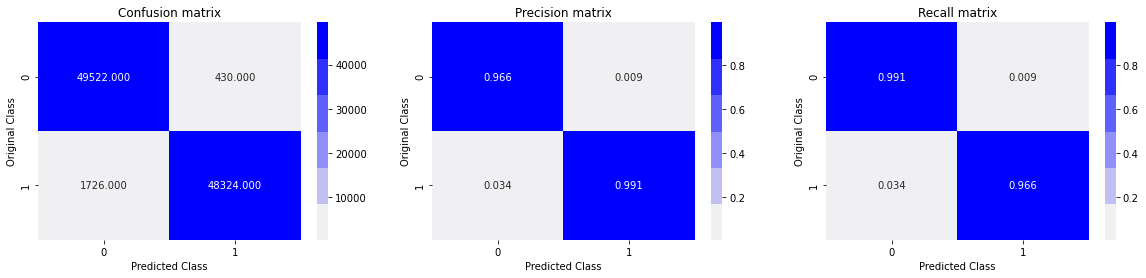

Test confusion_matrix


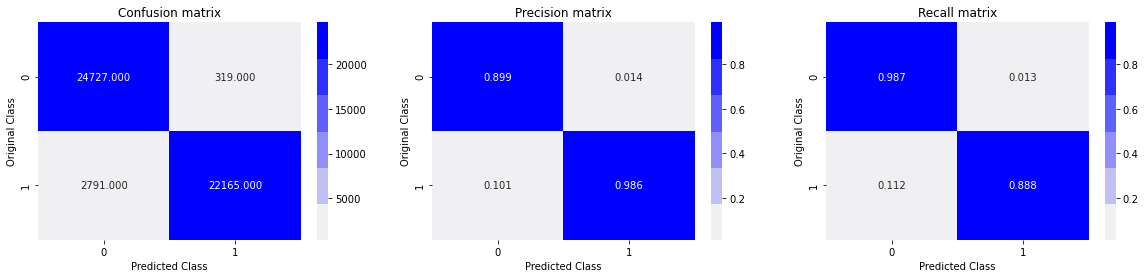

In [27]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

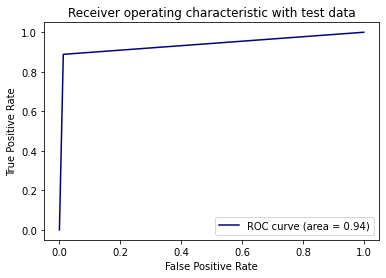

In [28]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

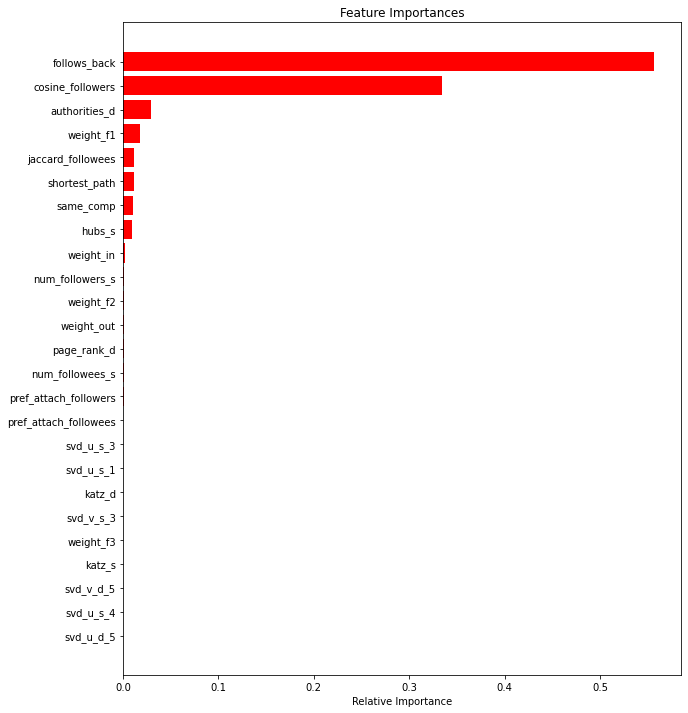

In [29]:
features = df_final_train.columns
importances = best_clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()